Make sure to run every cell in the file in the correct order.

In [ ]:
!pip3 install swig > /dev/null 2>&1
!pip3 uninstall box2d-py -y > /dev/null 2>&1
!pip3 install box2d-py > /dev/null 2>&1
!pip3 install box2d box2d-kengz > /dev/null 2>&1
!apt install xvfb > /dev/null 2>&1
!pip3 install pyvirtualdisplay > /dev/null 2>&1
!pip3 install gym==0.25.0 > /dev/null 2>&1

In [ ]:
import gym
import random
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
from pyvirtualdisplay import Display
from IPython import display as disp
import copy
from typing import Tuple
%matplotlib inline

### Implementing TD3 with MaxEnt

We provide you with the following utility function that implements the replay buffer for experience replay.

In [ ]:
# Replay buffer
class ReplayBuffer(object):
	def __init__(self, state_dim, action_dim, max_size=int(1e6)):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0

		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.next_state = np.zeros((max_size, state_dim))
		self.reward = np.zeros((max_size, 1))
		self.not_done = np.zeros((max_size, 1))

		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


	def add(self, state, action, next_state, reward, done):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.not_done[self.ptr] = 1. - done

		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)


	def sample(self, batch_size):
		ind = np.random.randint(0, self.size, size=batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.not_done[ind]).to(self.device)
		)


Now we are coming to the most exciting part--- try out DDPG (and optionally, TD3) on ``MountainCarContinuous`` environment! The hyperparameters are provided in the following cell. Note that they apply for both DDPG and TD3. To make the training process more stable, we will first randomly sample from the action space to fullfill our replay buffer. So don't panick if you find the reward in the innitial episodes is super low! You are welcome to change angthing in the training process as long as you find it helpful!



In [ ]:
def init_flags():

    flags = {
        "env": "MountainCarContinuous",
        "seed":0, # random seed
        "start_timesteps": 25e3, #total steps of free exploration phase
        "max_timesteps": 8e4, # maximum length of time steps in training
        "expl_noise": 0.1, # noise strength in exploration
        "batch_size": 512,
        "discount":0.99,
        "tau": 0.005, # rate of target update
        "policy_noise": 0.2, # policy noise when sampling action
        "noise_clip":0.5, # noise clip rate
        "policy_freq": 2, # delayed policy update frequency in TD3
    }

    return flags

def main(policy_name = 'DDPG') -> list:
    """
    Input:
    policy_name: str, the method to implement
    Output:
    evaluations: list, the reward in every episodes
    Call DDPG/TD3 trainer and
    """
    args = init_flags()
    env = gym.make(args["env"])
    env.seed(args["seed"]+100)
    env.action_space.seed(args["seed"])
    torch.manual_seed(args["seed"])
    np.random.seed(args["seed"])

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    kwargs = {
        "state_dim": state_dim,
        "action_dim": action_dim,
        "max_action": max_action,
        "discount": args["discount"],
        "tau": args["tau"],}
    if policy_name == "TD3":
        # Target policy smoothing is scaled wrt the action scale
        kwargs["policy_noise"] = args["policy_noise"] * max_action
        kwargs["noise_clip"] = args["noise_clip"] * max_action
        kwargs["policy_freq"] = args["policy_freq"]
        policy = TD3(**kwargs)
    elif policy_name == "DDPG":
        policy = DDPG(**kwargs)

    replay_buffer = ReplayBuffer(state_dim, action_dim)
    evaluations = []
    actions_l = []
    entropies = []
    means = []
    varis = []
    state, done = env.reset(), False
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0

    for t in range(int(args["max_timesteps"])):

      episode_timesteps += 1

      # Select action randomly or according to policy
      entropy = 0
      mean = 0
      vari = 0
      if t < args["start_timesteps"]:
        action = env.action_space.sample()
      else:
        action, entropy, mean, vari = (
          policy.select_action(np.array(state))
          # + np.random.normal(0, max_action * args["expl_noise"], size=action_dim)
        )# .clip(-max_action, max_action)

      # Perform action
      next_state, reward, done, _ = env.step(action)
      done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

      # Store data in replay buffer
      replay_buffer.add(state, action, next_state, reward, done_bool)

      state = next_state
      actions_l.append(action)
      entropies.append(entropy)
      means.append(mean)
      varis.append(vari)
      episode_reward += reward

      # Train agent after collecting sufficient data
      if t >= args["start_timesteps"]:
        policy.train(replay_buffer, args["batch_size"])

      if done:
        # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        evaluations.append(episode_reward)
        # print('a', actions_l)
        # print('e', entropies)
        # print('mu', means)
        # print('var', varis)
        entropies = []
        actions_l = []
        means = []
        varis = []
        # Reset environment
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1

    return evaluations


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Question 3. TD3 [Optional]

Similar to DDPG, TD3 also maintains a continuous actor update with deterministic policy gradient, a replay buffer with an exploratory strategy. The different between TD3 and DDPG lies in the critic update. Unlike Double DQN, due to the slow update of the policy (the $\theta$ in previous examples), the current and target value still remains similar even when using a double Q-update technique. While the implementation of an independent target network allows for a less biased value estimation, even an unbiased estimate with high variance can still lead to future overestimations in local regions of state space, which in turn can negatively affect the global policy.

To address this issue, TD3 updates the actor/critic network in the following way:

**(1)** TD3 maintains **6 neural networks**: $Q_{\phi_1}, Q_{\phi_2}$ as two independent update for the Q function, $Q_{\phi_1'}, Q_{\phi_2'}$ as their corresponding target networks, and $\mu_\theta, \mu_{\theta'}$ as the actor and its target network. $Q_{\phi_1}$ and $Q_{\phi_2}$ are independently initialized, and all target networks are initialized to be the same as their corresponding counterparts. When updating Q-functions, in every epidsode, DDPG updates the critic $Q_\phi$ by performing gradient descent with the following improved Bellamn loss: $$
L(\phi_i) = \text{mean}_t f(y_t, Q_{\phi_i}(s_t,a_t)),
$$
where $y_t = r(s_t, a_t) + \gamma \cdot \min_{i= 1,2}Q_{\phi_i'}(s_{t+1}, \tilde{a}_{t+1})$, $\tilde{a}_t =  \mu_{\theta'}(s_{t+1}) + \text{clip}_{[-c,c]}(\mathcal{N}(0,\tilde{\sigma}))$,  which is different from the TD target in DDPG, as it take the minimum of the two future Q-values and a "disturbed" future action. Here we clip $\tilde{a}_t$ to prevent it from going too far. Intuitively, TD3 evaluates the Q-value of $s_{t+1}$ in a more "conservative" way.


**(2)** When updating $\mu_\theta$, TD3 only utilizes $Q_{\phi_1}$:$$
\Delta \theta = \eta\cdot \text{mean}_t \big(\nabla_a Q_{\phi_1}(s_t, \mu_\theta(s_t)) \cdot \nabla_\theta \mu_\theta (s_t)\big).
$$
At the end of every episode, similar to DDPG, all parameters are updated by $$
\phi_i' = \tau \phi_i + (1 - \tau) \phi_i', \qquad \theta' = \tau \theta + (1 - \tau) \theta'.
$$

**(3)** The actor update is delayed: it only updates once every several times the critic updates.


We understand the introduction above might be a little bit confusing due to the technical complexity. In the following, we will guide you end to end to implement a TD3 training algorithm.



In the following cell, we will implement the actor and critic network for TD3. For the actor and every critic (we need to maintain an additional critic), please make sure it has the same structure as the one in the previous DDPG question so that we can conduct an ablation study.

Our implementation for the ``Critic_TD3`` class is slightly different from the previous critic in DDPG: the class function ``forward`` should return two values $q_1$ and $q_2$ given $(s,a)$, while the class function ``Q1`` should return only $q_1$.

In [ ]:
# Implementation of Twin Delayed Deep Deterministic Policy Gradients (TD3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Construct the actor/critic network for TD3
class Actor_TD3(nn.Module):
	def __init__(self, state_dim: int, action_dim: int, max_action: float):
		super(Actor_TD3, self).__init__()
		############################
		# YOUR IMPLEMENTATION HERE #
		# [HINT] make sure the structure is the same as DDPG
		# self.l1 = nn.Linear(state_dim, 256)
		# self.l2 = nn.Linear(256, 256)
		# self.l3 = nn.Linear(256, action_dim)
		# ############################
		# self.max_action = max_action

		self.split_dim = 64
		self.l1 = nn.Linear(state_dim, 256)
		self.l2 = nn.Linear(256, 256)
		self.l3 = nn.Linear(256, 2 * self.split_dim)

		self.mu_l1 = nn.Linear(self.split_dim, self.split_dim)
		self.mu_l2 = nn.Linear(self.split_dim, 1)
		self.var_l1 = nn.Linear(self.split_dim, self.split_dim)
		self.var_l2 = nn.Linear(self.split_dim, 1)
		self.policy_distribution = None
		self.eps = 1e-9
		############################
		self.max_action = max_action


	def forward(self, state):
		############################
		# YOUR IMPLEMENTATION HERE #
		a = F.relu(self.l1(state))
		a = F.relu(self.l2(a))
		out = self.l3(a)
		# print('out', out.shape)
		mu = self.max_action * (self.mu_l2(F.relu(self.mu_l1(out[...,:self.split_dim]))))
		sig = 2 * F.sigmoid(self.var_l2(F.relu(self.var_l1(out[...,self.split_dim:]))) + self.eps)

		self.policy_distribution = torch.distributions.normal.Normal(mu, sig)
		return self.policy_distribution

	def extract_params (self, state):
		############################
		# EXTRA DEBUGGING FUNCTION #
		a = F.relu(self.l1(state))
		a = F.relu(self.l2(a))
		out = self.l3(a)
		# print('out', out.shape)
		mu = self.max_action * (self.mu_l2(F.relu(self.mu_l1(out[...,:self.split_dim]))))
		sig = 2 * F.sigmoid(self.var_l2(F.relu(self.var_l1(out[...,self.split_dim:]))) + self.eps)

		# print('mu', mu)
		# print('sigma', sig)

		self.policy_distribution = torch.distributions.normal.Normal(mu, sig)
		return self.policy_distribution, mu, sig


class Critic_TD3(nn.Module):
	def __init__(self, state_dim : int, action_dim: int):
		super(Critic_TD3, self).__init__()

		# Q1 architecture
		############################
		# YOUR IMPLEMENTATION HERE #
		self.l1 = nn.Linear(state_dim + action_dim, 128)
		self.l2 = nn.Linear(128, 128)
		self.l3 = nn.Linear(128, 1)

		# Please implement Q2 below
		############################
		# YOUR IMPLEMENTATION HERE #
		self.l4 = nn.Linear(state_dim + action_dim, 128)
		self.l5 = nn.Linear(128, 128)
		self.l6 = nn.Linear(128, 1)
		############################

	def forward(self, state: torch.Tensor, action: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
		sa = torch.cat([state, action], 1)
		############################
		# YOUR IMPLEMENTATION HERE #
		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)

		q2 = F.relu(self.l4(sa))
		q2 = F.relu(self.l5(q2))
		q2 = self.l6(q2)
		############################
		return q1, q2


	def Q1(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
		# [HINT] only returns q1 for actor update
		############################
		# YOUR IMPLEMENTATION HERE #
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)
	  ############################
		return q1


Now let's implement the TD3 trainer! In the following cell, you will need to implement the following:

**(1)** For the critic update of TD3, when sampled a tuple from the replay buffer, recall that we need to estimate $Q(s_{t+1},\tilde{a}_{t+1})$, where $\tilde{a}_{t+1} = \mu_{\theta'}(s_{t+1})+\text{clip}_{[-c,c]}(\epsilon)$ .

**(2)** Calculate the TD target with the networks $Q_{\phi_i'}, i=1,2,$ and $(s_{t+1}, \tilde{a}_{t+1})$ you obtained in **(1)**. Recall that the TD target = $r(s_t,a_t) + \min_{i=1,2}\{Q_{\phi_i'}(s_{t+1}, \tilde{a}_{t+1})\}$.

**(3)** Calculate the actor loss with $Q_{\phi_1}$.

**(4)** Update the parameters $\phi_i'$, $\theta'$.

In [ ]:
class TD3(object):
	def __init__(
		self,
		state_dim: int,
		action_dim: int,
		max_action: float,
		discount=0.99,
		tau=0.005,
		policy_noise=0.2,
		noise_clip=0.5,
		policy_freq=2
	):

		self.actor = Actor_TD3(state_dim, action_dim, max_action).to(device)
		self.actor_target = copy.deepcopy(self.actor)
		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

		self.critic = Critic_TD3(state_dim, action_dim).to(device)
		self.critic_target = copy.deepcopy(self.critic)
		self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

		self.max_action = max_action
		self.discount = discount
		self.tau = tau
		self.policy_noise = policy_noise
		self.noise_clip = noise_clip
		self.policy_freq = policy_freq

		self.alpha = 0.02

		self.total_it = 0


	def select_action(self, state: torch.Tensor) -> torch.Tensor:
		state = torch.FloatTensor(state.reshape(1, -1)).to(device)
		distribution, mean, vari = self.actor.extract_params(state)
		action = distribution.sample().clip(-self.actor.max_action, self.actor.max_action)
		entropy = distribution.entropy()
		# entropy = -distribution.log_prob(action)
		return action.cpu().data.numpy().flatten(), entropy.cpu().data.numpy().flatten(), mean.cpu().data.numpy().flatten(), vari.cpu().data.numpy().flatten()

		# state = torch.FloatTensor(state.reshape(1, -1)).to(device)
		# distribution = self.actor.forward(state)
		# action = distribution.sample().clip(-self.actor.max_action, self.actor.max_action)
		# return action.cpu().data.numpy().flatten()


	def train(self, replay_buffer, batch_size=256):
		self.total_it += 1

		# Sample replay buffer
		state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

		with torch.no_grad():
			# Select action according to policy and add clipped noise.
      # [HINT]: You can use ().clamp(-self.noise_clip, self.noise_clip) to clip the noise
      ############################
      # YOUR IMPLEMENTATION HERE #
			# noise = (
			# 	torch.randn_like(action) * self.policy_noise
			# ).clamp(-self.noise_clip, self.noise_clip)

			distribution = self.actor_target(next_state)
			next_action = distribution.sample().clip(-self.actor.max_action, self.actor.max_action)
			entropy = distribution.entropy()

			# next_action = (
			# 	self.actor_target(next_state)
			# ).clamp(-self.max_action, self.max_action)
      ############################
			# Compute the target Q value
			target_Q1, target_Q2 = self.critic_target(next_state, next_action)

      ############################
      # YOUR IMPLEMENTATION HERE #
			# 1.Calculate the min of two target Q-functions
			# 2. Calculate the TD target
			target_Q = torch.min(target_Q1, target_Q2) + self.alpha * entropy
			target_Q = reward + not_done * self.discount * target_Q
      ############################
		# Get current Q estimates
		current_Q1, current_Q2 = self.critic(state, action)

		# Compute critic loss
		critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

		# Optimize the critic
		self.critic_optimizer.zero_grad()
		critic_loss.backward()
		self.critic_optimizer.step()

		# Delayed policy updates
		if self.total_it % self.policy_freq == 0:

			# Compute actor loss
      ############################
      # YOUR IMPLEMENTATION HERE #
			curr_distribution = self.actor(state)
			actions = curr_distribution.rsample().clip(-self.actor.max_action, self.actor.max_action)
			a_entropy = curr_distribution.entropy()
			actor_loss = -(self.critic.Q1(state, actions) + self.alpha * a_entropy).mean()
      ############################

			# Optimize the actor
			self.actor_optimizer.zero_grad()
			actor_loss.backward()
			self.actor_optimizer.step()

			# Update the frozen target models
      ############################
      # YOUR IMPLEMENTATION HERE #
			for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
				new_target_params = self.tau * param.data + (1 - self.tau) * target_param.data
				target_param.data.copy_(new_target_params)

			for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
				new_target_params = self.tau * param.data + (1 - self.tau) * target_param.data
				target_param.data.copy_(new_target_params)
      ############################



In [ ]:
evaluation_td3 = main(policy_name = 'TD3')

Total T: 112 Episode Num: 1 Episode T: 112 Reward: 95.797
a [array([0.27392337], dtype=float32), array([-0.46042657], dtype=float32), array([-0.918053], dtype=float32), array([-0.96694475], dtype=float32), array([0.6265405], dtype=float32), array([0.82551116], dtype=float32), array([0.21327156], dtype=float32), array([0.4589931], dtype=float32), array([0.08724998], dtype=float32), array([0.87014484], dtype=float32), array([0.63170713], dtype=float32), array([-0.994523], dtype=float32), array([0.7148085], dtype=float32), array([-0.93282884], dtype=float32), array([0.4593109], dtype=float32), array([-0.64868873], dtype=float32), array([0.7263578], dtype=float32), array([0.08292244], dtype=float32), array([-0.4005762], dtype=float32), array([-0.15462556], dtype=float32), array([-0.9433607], dtype=float32), array([-0.75143343], dtype=float32), array([0.34124884], dtype=float32), array([0.29437903], dtype=float32), array([0.23077023], dtype=float32), array([-0.23264489], dtype=float32), arr

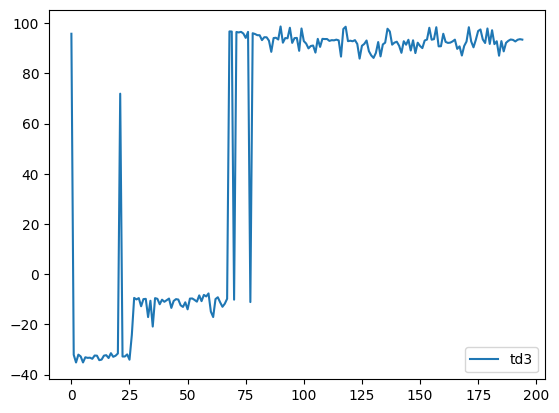

In [ ]:
plt.plot(evaluation_td3, label = 'td3')
# plt.plot(evaluations_ddpg, label = 'ddpg')
plt.legend()